In [10]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.data.shape)
print boston.feature_names

(506, 13)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [5]:
dfX = boston.data
dfY = np.array([boston.target]).transpose()
print dfY.shape
assert dfX.shape[0] == dfY.shape[0]
n = dfX.shape[0]


(506, 1)


In [7]:
test_split_rule = [i % 7 == 0 for i in range(n)]
train_split_rule = np.invert(test_split_rule)
testX, testY = dfX[test_split_rule], dfY[test_split_rule]
trainX, trainY = dfX[train_split_rule], dfY[train_split_rule]

/home/tg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  app.launch_new_instance()


# 1. Histograms and pearson correlation



Correlations
          0         1         2         3         4         5         6   \
0   1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  -0.196820  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.395365 -0.536541  1.000000  0.000000  0.000000  0.000000  0.000000   
3  -0.054033 -0.038433  0.050390  1.000000  0.000000  0.000000  0.000000   
4   0.409575 -0.524688  0.767571  0.065168  1.000000  0.000000  0.000000   
5  -0.206116  0.313503 -0.386934  0.066406 -0.308186  1.000000  0.000000   
6   0.351001 -0.584893  0.653162  0.080992  0.732418 -0.238638  1.000000   
7  -0.369524  0.670814 -0.712094 -0.097233 -0.769830  0.208917 -0.748355   
8   0.605845 -0.316902  0.595654 -0.021496  0.609953 -0.211188  0.469509   
9   0.565724 -0.317761  0.720845 -0.051192  0.667141 -0.287639  0.519360   
10  0.278720 -0.382931  0.375162 -0.145086  0.183181 -0.356103  0.264255   
11 -0.357936  0.179615 -0.359181  0.054768 -0.385611  0.134576 -0.283397   

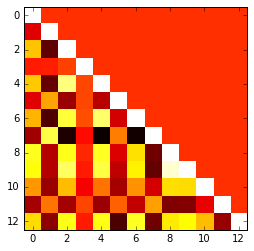

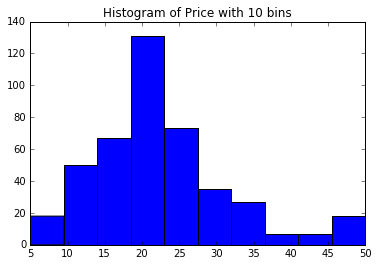

Histogram


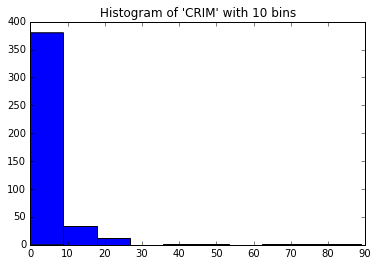

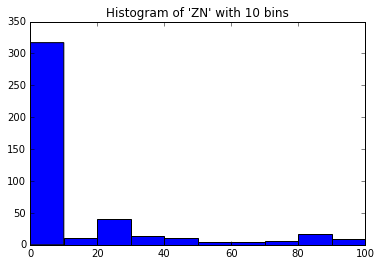

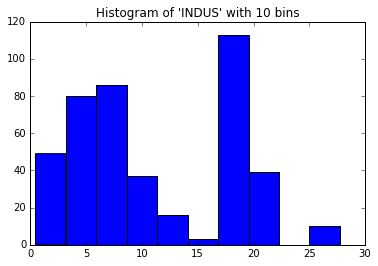

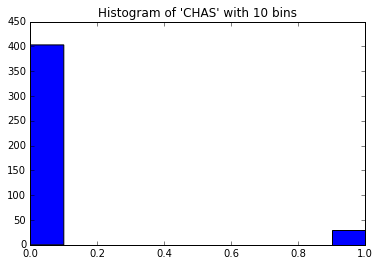

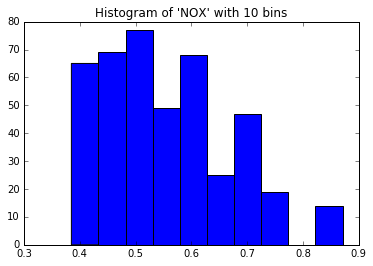

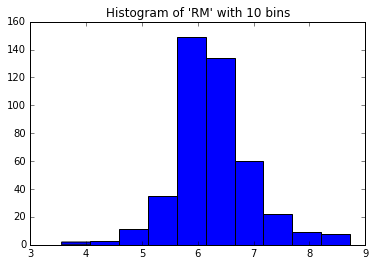

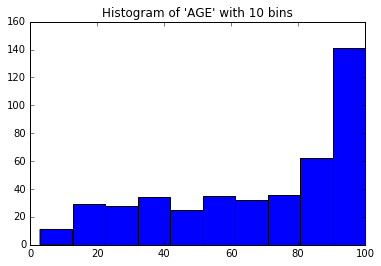

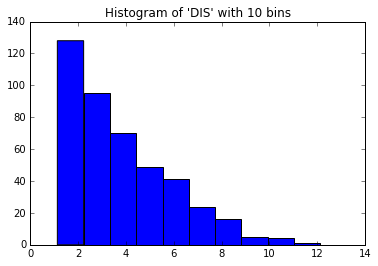

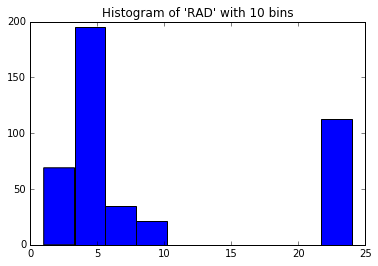

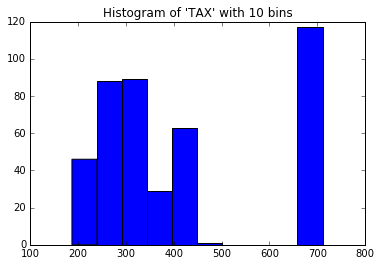

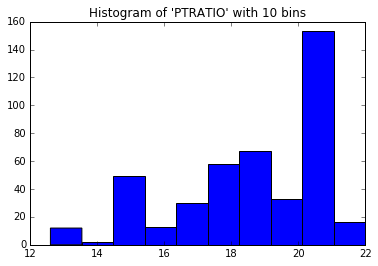

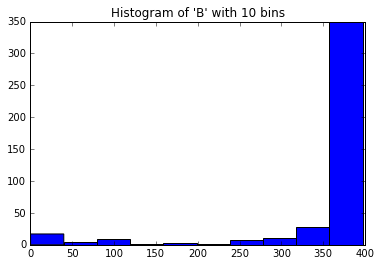

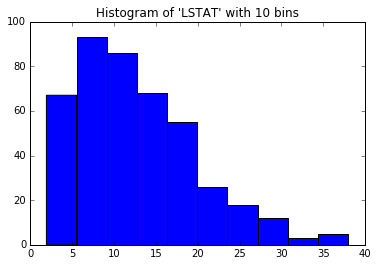

In [42]:
# compute means and stds

n_attrs = trainX.shape[1]
attrs = [ trainX[:, i] for i in range(n_attrs)]
distribs = [(a.mean(), a.std())for a in attrs]

corrs = np.zeros(shape=(n_attrs, n_attrs))
for i, a in enumerate(attrs):
    for j in range(0, i + 1):
        b = attrs[j]
        # COV[A,B] = E[X - muX] E[Y - muY] = E[XY] - E[X]E[Y]
        # Pearson CORR[A, B] = COV[A,B] / (sigmaX * sigmaY)
        cov_ab = np.multiply(a, b).mean() - distribs[i][0] * distribs[j][0]
        cor_ab = cov_ab / (distribs[i][1] * distribs[j][1])
        corrs[i][j] = cor_ab

print("Correlations")
print(pd.DataFrame(corrs))
plt.imshow(corrs, cmap='hot', interpolation='nearest')
plt.show()

plt.hist(trainY, bins=bins)
plt.title("Histogram of Price with %d bins" % bins)
plt.show()

print("Histogram")
bins = 10
for i, attr in enumerate(attrs):
    plt.hist(attr, bins=bins)
    plt.title("Histogram of '%s' with %d bins" % (boston.feature_names[i], bins))
    plt.show()



In [45]:
means = trainX.mean(axis=0)
stds = trainX.std(axis=0)
X = (trainX - means ) / stds
Y = trainY
n_rows, n_attrs = X.shape

'''
W = np.random.rand(n_attrs, 1)
b = 0.0
predY = np.matmul(X, W) + b
'''

# Alternatively , we can pack 'b' inside the vector W by insering '1' to X
X = np.insert(X, 0, 1, axis=1)
n_rows, n_attrs = X.shape
W = np.random.rand(n_attrs, 1)


def predict(X, W):
    return np.matmul(X, W)
    
def cost(predY, Y):
    return float(np.sum((predY - Y) ** 2))

def gradient_desc(X, Y, W, alpha, num_iterations = 10, conv_tol=0.01, print_interval = 10):
    c = float('inf')
    for i in range(num_iterations):
        
        predY = predict(X, W)
        diff = predY - Y
        delta = np.sum(np.multiply(X, diff), axis=0) # sum top to bottom for each attribute
        delta = np.array([delta]).transpose()        # restore vector shape of (n_attr x 1)
        W = (W - alpha * delta)
        if i % print_interval == 0:
            newcost = cost(predict(X, W), Y)
            if np.isnan(newcost) or np.isinf(newcost) or np.isneginf(newcost):
                print("ERROR: number overflow, please adjust learning rate")
                return None
            diff = abs(newcost - c)
            c = newcost
            print("#%d, cost = %.8g" % (i, c))
            if diff < conv_tol:
                print("Converged with tolerance %f " % conv_tol)
                break            
        if i % (print_interval * 10) == 0:
            print(W.flatten())
    return W

alpha = 0.0001
optW = gradient_desc(X, Y, W, alpha, num_iterations=1000, print_interval=50)
print(optW.shape)
predY = predict(X, optW)
result = np.concatenate((Y, predY), axis=1)
print(result)

#0, cost = 222985.02
[ 1.66415418  0.56245102  0.48995803  0.11610883  0.12050596  0.19573621
  0.38616145 -0.03187936  0.6330214   0.29876563  0.01954485  0.33819725
  0.19123824 -0.05694433]
#50, cost = 12162.962
#100, cost = 9483.6463
#150, cost = 9282.5758
#200, cost = 9196.4556
#250, cost = 9150.6553
#300, cost = 9124.4538
#350, cost = 9108.4452
#400, cost = 9098.0681
#450, cost = 9091.004
#500, cost = 9086.0124
[ 22.46351039  -0.92964454   0.97161669  -0.35322531   0.95072047
  -1.52866124   2.7704813   -0.30489483  -3.07608681   2.01845253
  -1.40385479  -1.85777896   0.82733621  -3.65795058]
#550, cost = 9082.39
#600, cost = 9079.7132
#650, cost = 9077.7117
#700, cost = 9076.2035
#750, cost = 9075.0615
#800, cost = 9074.1942
#850, cost = 9073.5342
#900, cost = 9073.0313
#950, cost = 9072.6479
(14, 1)
[[ 21.6         24.67124261]
 [ 34.7         30.47769221]
 [ 33.4         28.85818401]
 [ 36.2         28.14891493]
 [ 28.7         25.30333782]
 [ 22.9         22.69746041]
 [ 16.

In [27]:
np.multiply(trainX[:, 1], trainX[:, 1])


array([     0.  ,      0.  ,      0.  ,      0.  ,      0.  ,    156.25,
          156.25,    156.25,    156.25,    156.25,    156.25,      0.  ,
            0.  ,      0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
            0.  ,      0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
            0.  ,      0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
            0.  ,      0.  ,      0.  ,   5625.  ,   5625.  ,      0.  ,
            0.  ,      0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
          441.  ,    441.  ,    441.  ,    441.  ,   5625.  ,   8100.  ,
        10000.  ,    625.  ,    625.  ,    625.  ,    625.  ,    625.  ,
          306.25,   6400.  ,   6400.  ,    156.25,    156.25,    156.25,
            0.  ,      0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
            0.  ,      0.  ,    625.  ,    625.  ,    625.  ,    625.  ,
            0.  ,      0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
          784.  ,    784.  ,    784.  ,      0.  , 